# Scanning the MIRI fringes can tell us about the local properties of the MIRI SW detector
Here we attempt to fit the fringes with an "optimized" transmittance function. We do this by scanning through the fringe transmission profile, with a scan width being equal to the period of the fringes. For practical reasons the analysis is done in wavenumber space (we help ourselves with the fact that, for a plane-parallel system, the distance between etalon lines should be constant in wavenumber).

## > Import modules

In [1]:
import funcs
import mrsobs

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import InterpolatedUnivariateSpline,interp1d
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

## > Get data
We load the images for one band of the MRS for different kinds of sources, including: 
* MTS 800K BB extended source
* MTS 800K BB extended source observed through etalon "ET1A"
* MTS 800K BB extended source observed through 100micron pinhole 
  
Additionally the pixel-to-wavelength calibration map, the MRS spectral resolution table, and the pixel-to-along-slice position map are imported.

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band = '1A'
ext_source_sci,ext_source_bkg           = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K')
ext_etal_source_sci,ext_etal_source_bkg = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET1A')
point_source_sci_p1,point_source_bkg_p1 = mrsobs.FM_MTS_800K_BB_point_source_raster(lvl2path,position='middle',pointing='P1')

# Get wavelength calibration pixel map
d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
lambdaMap = d2cMaps['lambdaMap']
wvnrMap   = 1./(lambdaMap/10000.)
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

# Get spectral resolution table
specres_table = funcs.get_cdps(cdpDir=cdpDir,band=band)[4]

## > Transform data
We subtract background exposures where available

In [3]:
# perform transform
ext_source_bkgsubtr      = ext_source_sci-ext_source_bkg
ext_etal_source_bkgsubtr = ext_etal_source_sci-ext_etal_source_bkg
point_source_p1_bkgsubtr = point_source_sci_p1-point_source_bkg_p1

We perform an even-odd row signal correction to the data (caused by the read-out pattern of MIRI detector pixel rows)

In [4]:
ext_source_oddevencorr      = funcs.OddEvenRowSignalCorrection(ext_source_bkgsubtr)
ext_etal_source_oddevencorr = funcs.OddEvenRowSignalCorrection(ext_etal_source_bkgsubtr)
point_source_p1_oddevencorr = funcs.OddEvenRowSignalCorrection(point_source_p1_bkgsubtr)

## > Modeling
As always we start by determining the fringe transmission. Then we optimize the Fabry-Pérot transmittance function parameters to fit parts of the fringe transmission, by essentially scanning through the fringes. The scan window is defined by the period of the fringes in wavenumber space, which is proportional to the optical thickness of the resonator.

In [5]:
# Pixel trace in MRS slice
sliceID,alpha_position = nslices/2,0.
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=nslices/2,alpha_pos=alpha_position)

# Normalize the extended source spectrum to the fringe peak profile
ext_source_norm = funcs.norm_fringe(ext_source_oddevencorr[ypos,xpos], thres=0.3, min_dist=6)

# Compute zeroth order optical thickness of detector from fringe peak separation
fringepeaks_wavelength     = lambdaMap[ypos,xpos][ext_source_norm[1]]       # microns
fringepeaks_wavenumber     = np.flipud(10000./fringepeaks_wavelength)       # cm-1
mean_fringepeak_separation = np.mean(np.diff(fringepeaks_wavenumber)[1:-1]) # omit first and last data point
# fit straight line through distance data for comparison
popt,pcov = curve_fit(funcs.straight_line,fringepeaks_wavenumber[1:-2],np.diff(fringepeaks_wavenumber)[1:-1])

print r'Mean etalon line separation in wavenumber space is: Δσ = {} cm-1'.format(round(mean_fringepeak_separation,2) )
print r'The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = {} um'.format(round(10000./(2*mean_fringepeak_separation),2) )

Mean etalon line separation in wavenumber space is: Δσ = 2.92 cm-1
The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = 1710.71 um


<IPython.core.display.Javascript object>


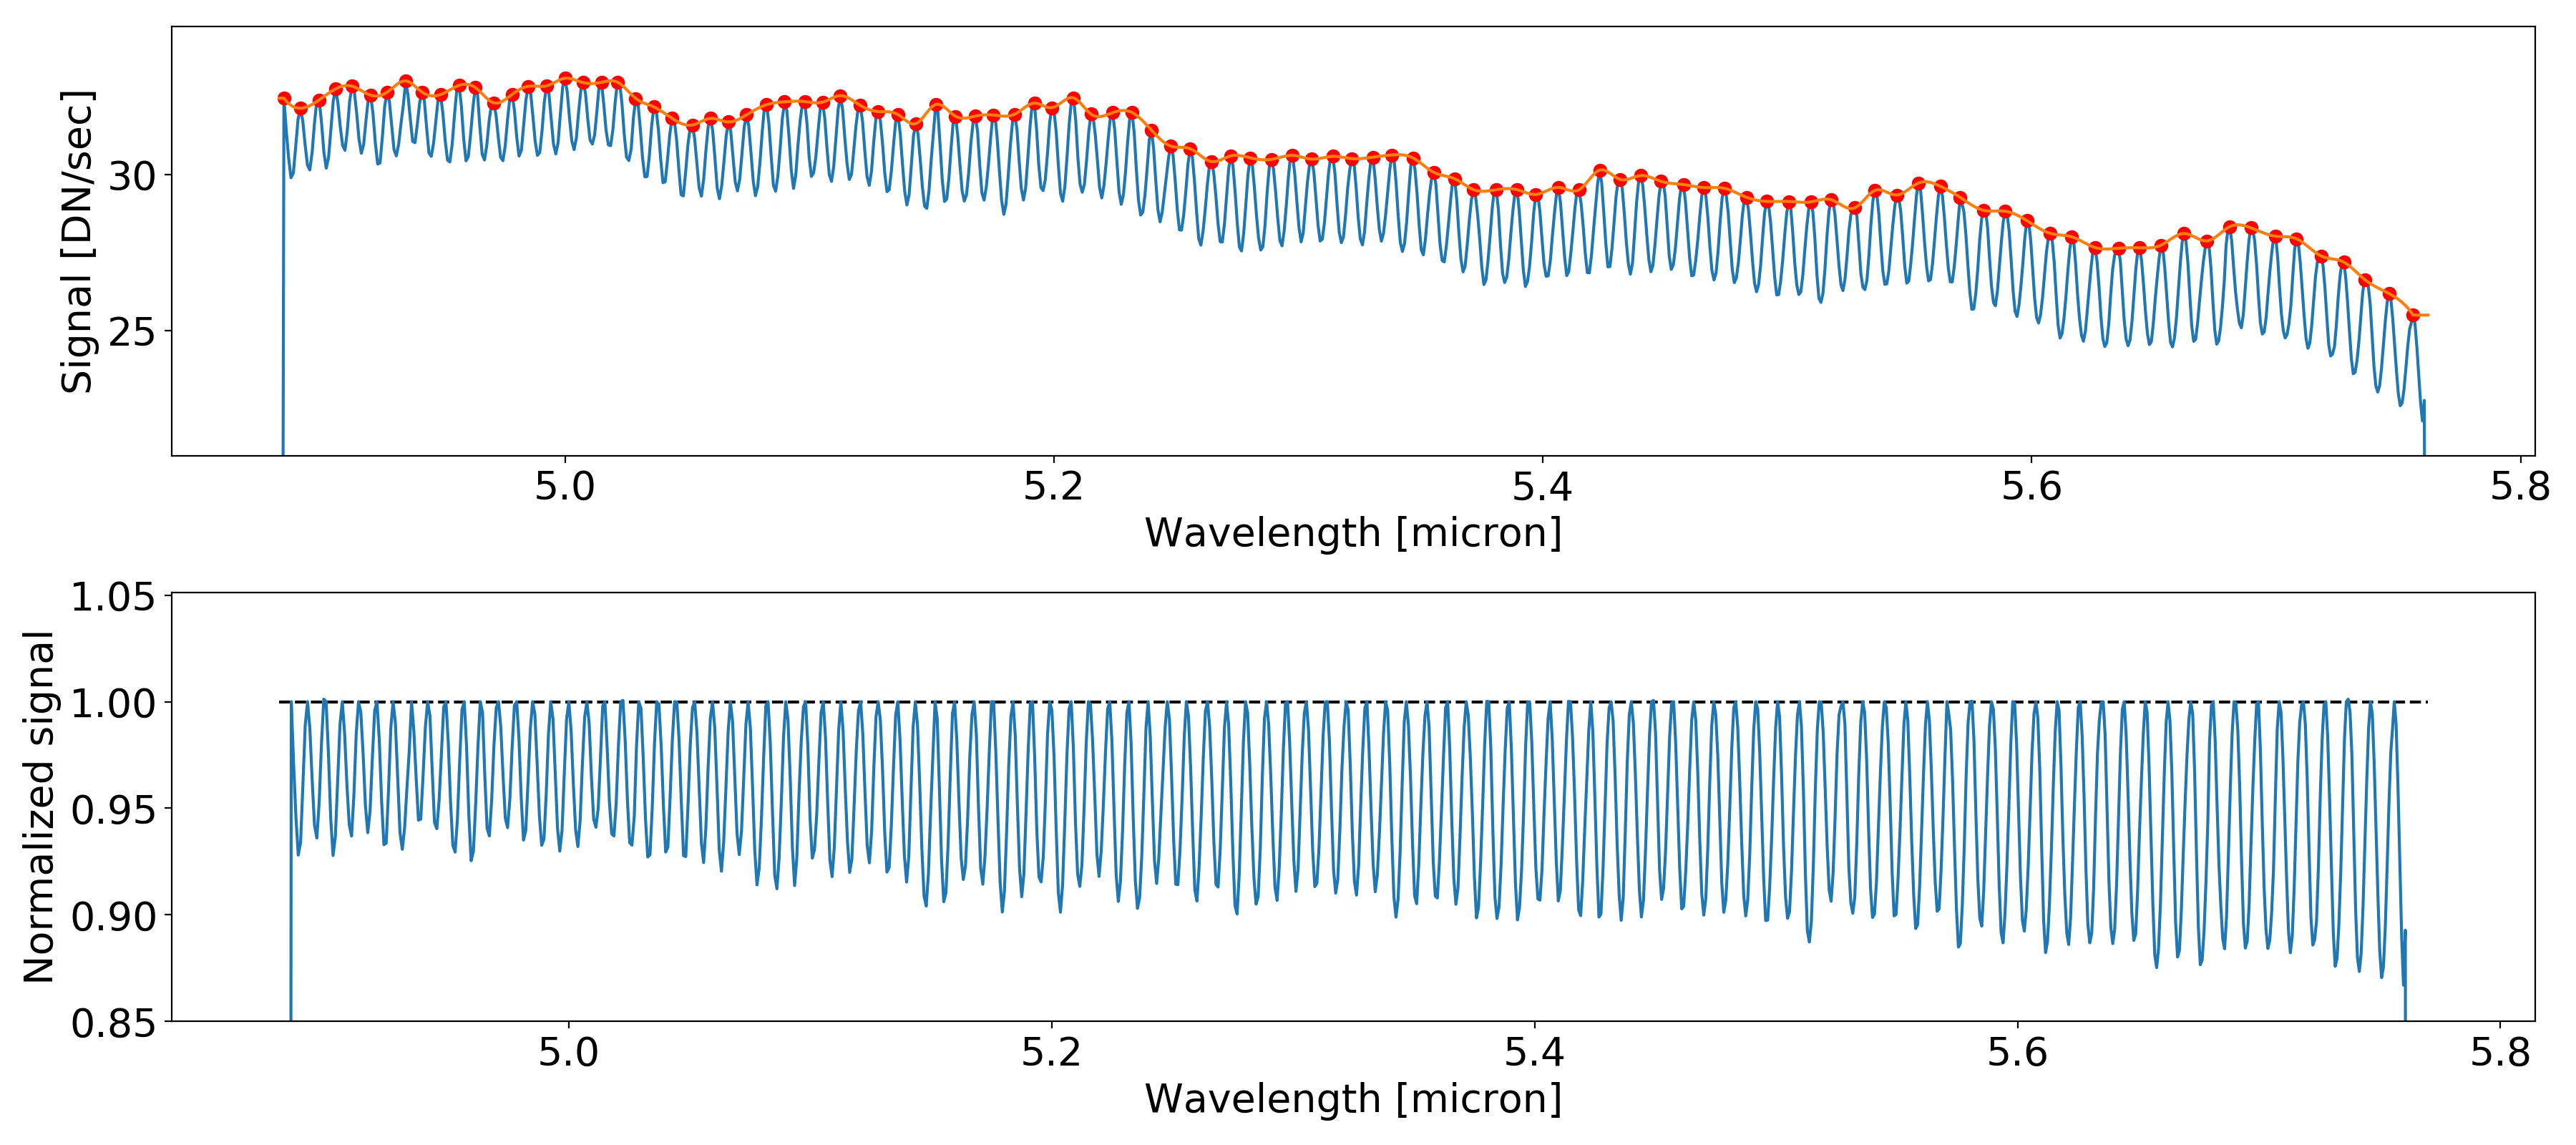

<IPython.core.display.Javascript object>


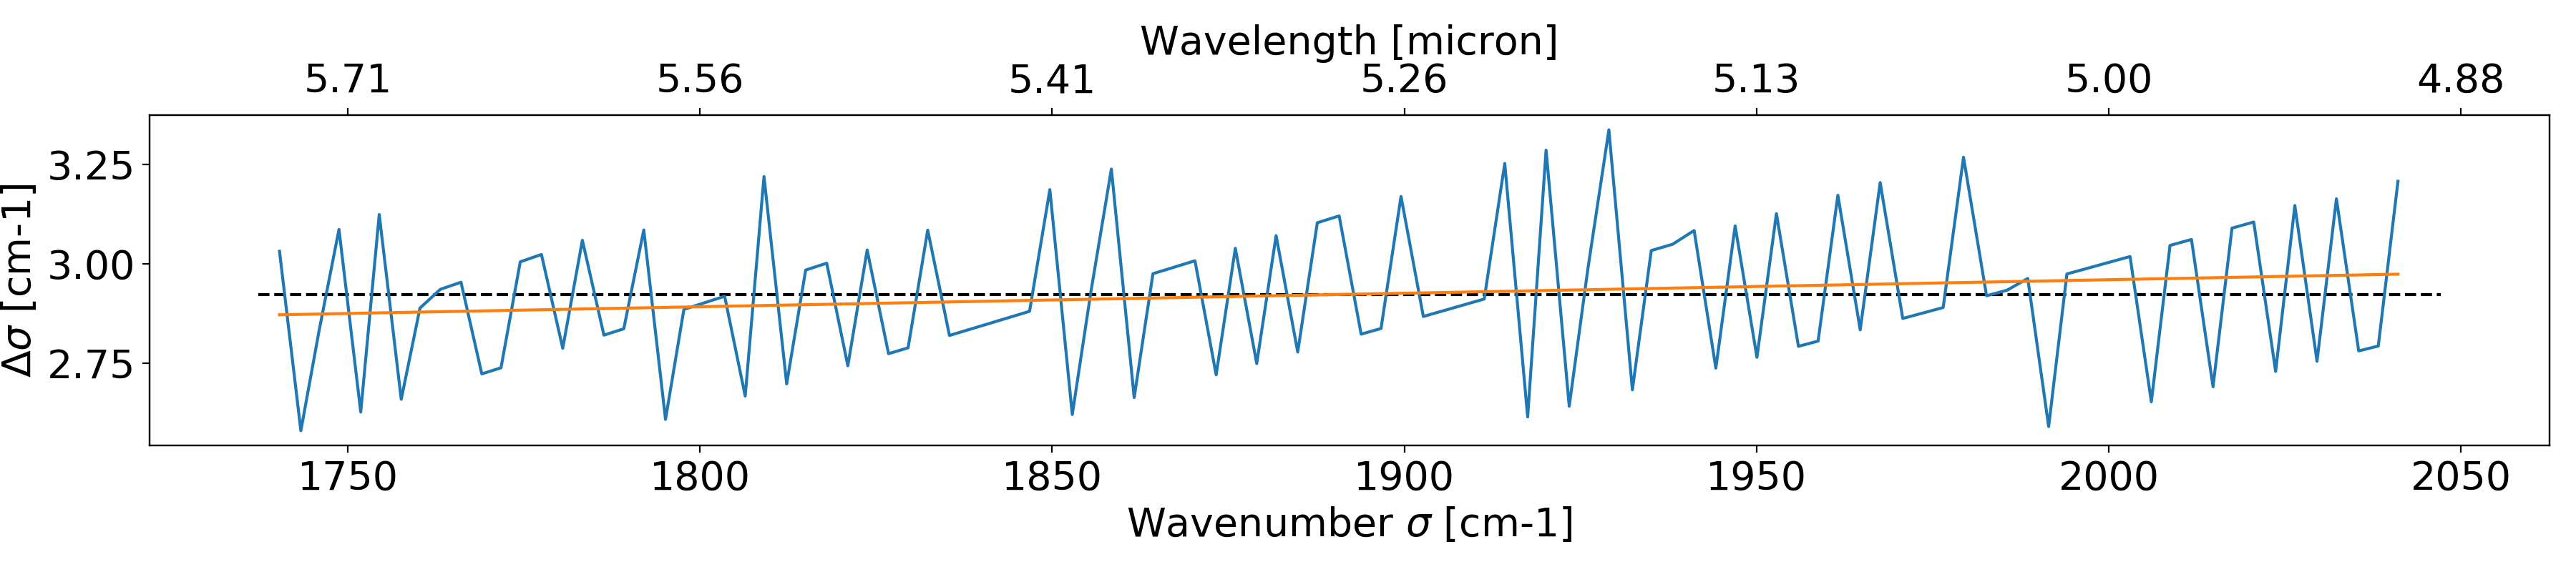

In [6]:
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].plot(lambdaMap[ypos,xpos],ext_source_norm[0])
axs[0].plot(lambdaMap[ypos,xpos][ext_source_norm[1]],ext_source_norm[0][ext_source_norm[1]],'ro')
axs[0].plot(lambdaMap[ypos,xpos],ext_source_norm[2])
axs[1].plot(lambdaMap[ypos,xpos],ext_source_norm[0]/ext_source_norm[2])
axs[1].hlines(1,4.88,5.77,linestyle='dashed')
axs[0].set_ylim(21)
axs[1].set_ylim(0.85)
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].set_ylabel('Normalized signal')
for plot in range(2):
    axs[plot].set_xlabel('Wavelength [micron]')
plt.tight_layout()

fig = plt.figure(figsize=(18,4))
axs1 = fig.add_subplot(111)
axs2 = axs1.twiny()
axs1.plot(fringepeaks_wavenumber[1:-2],np.diff(fringepeaks_wavenumber)[1:-1])
axs1.plot(fringepeaks_wavenumber[1:-2],funcs.straight_line(fringepeaks_wavenumber[1:-2],*popt))
axs1.hlines(mean_fringepeak_separation,fringepeaks_wavenumber[0],fringepeaks_wavenumber[-1],linestyle='dashed')
axs1.set_xlabel(r'Wavenumber $\sigma$ [cm-1]')
axs1.set_ylabel(r'$\Delta \sigma$ [cm-1]')
axs2.set_xlim(axs1.get_xlim())
tickmarks = np.array([1750.,1800.,1850.,1900.,1950.,2000.,2050.])
axs2.set_xticks(tickmarks)
axs2.set_xticklabels(funcs.tick_function(tickmarks))
axs2.set_xlabel('Wavelength [micron]')
plt.tight_layout()

In [7]:
wavenumbers = np.flipud(10000./lambdaMap[ypos,xpos])
norm_signal = np.flipud(ext_source_norm[0]/ext_source_norm[2])

# define scanning window (arbitrarily set to 2*period)
N=1
while wavenumbers[N]-wavenumbers[0] < 2*mean_fringepeak_separation: N+=1

# Scan fringes
R,D,sigma_R,sigma_D = [np.full(len(wavenumbers),np.nan) for j in range(4)]

R0,D0 = 0.10,1/(2*mean_fringepeak_separation)
for i in range(len(wavenumbers)-N):
    wvnr_segment = wavenumbers[i: N+i].copy()
    array_segment  = norm_signal[i: N+i].copy()

    # least-squares fitting
    try: 
        popt,pcov = curve_fit(funcs.FPfunc_noPhaseShift,wvnr_segment,array_segment,p0=(R0,D0),absolute_sigma=True,method='lm')
        TR = funcs.FPfunc_noPhaseShift(wvnr_segment,*popt)

        R[i: N+i] = popt[0]
        D[i: N+i] = popt[1]
        sigma_R[i: N+i] = np.sqrt(np.diag(pcov))[0]
        sigma_D[i: N+i] = np.sqrt(np.diag(pcov))[1]
        
    except RuntimeError: 
        continue
# take care about numerics!
R,D = funcs.cleanRD(R,D)

#> transmittance function
TR = funcs.FPfunc_noPhaseShift(wavenumbers,R,D)


<IPython.core.display.Javascript object>


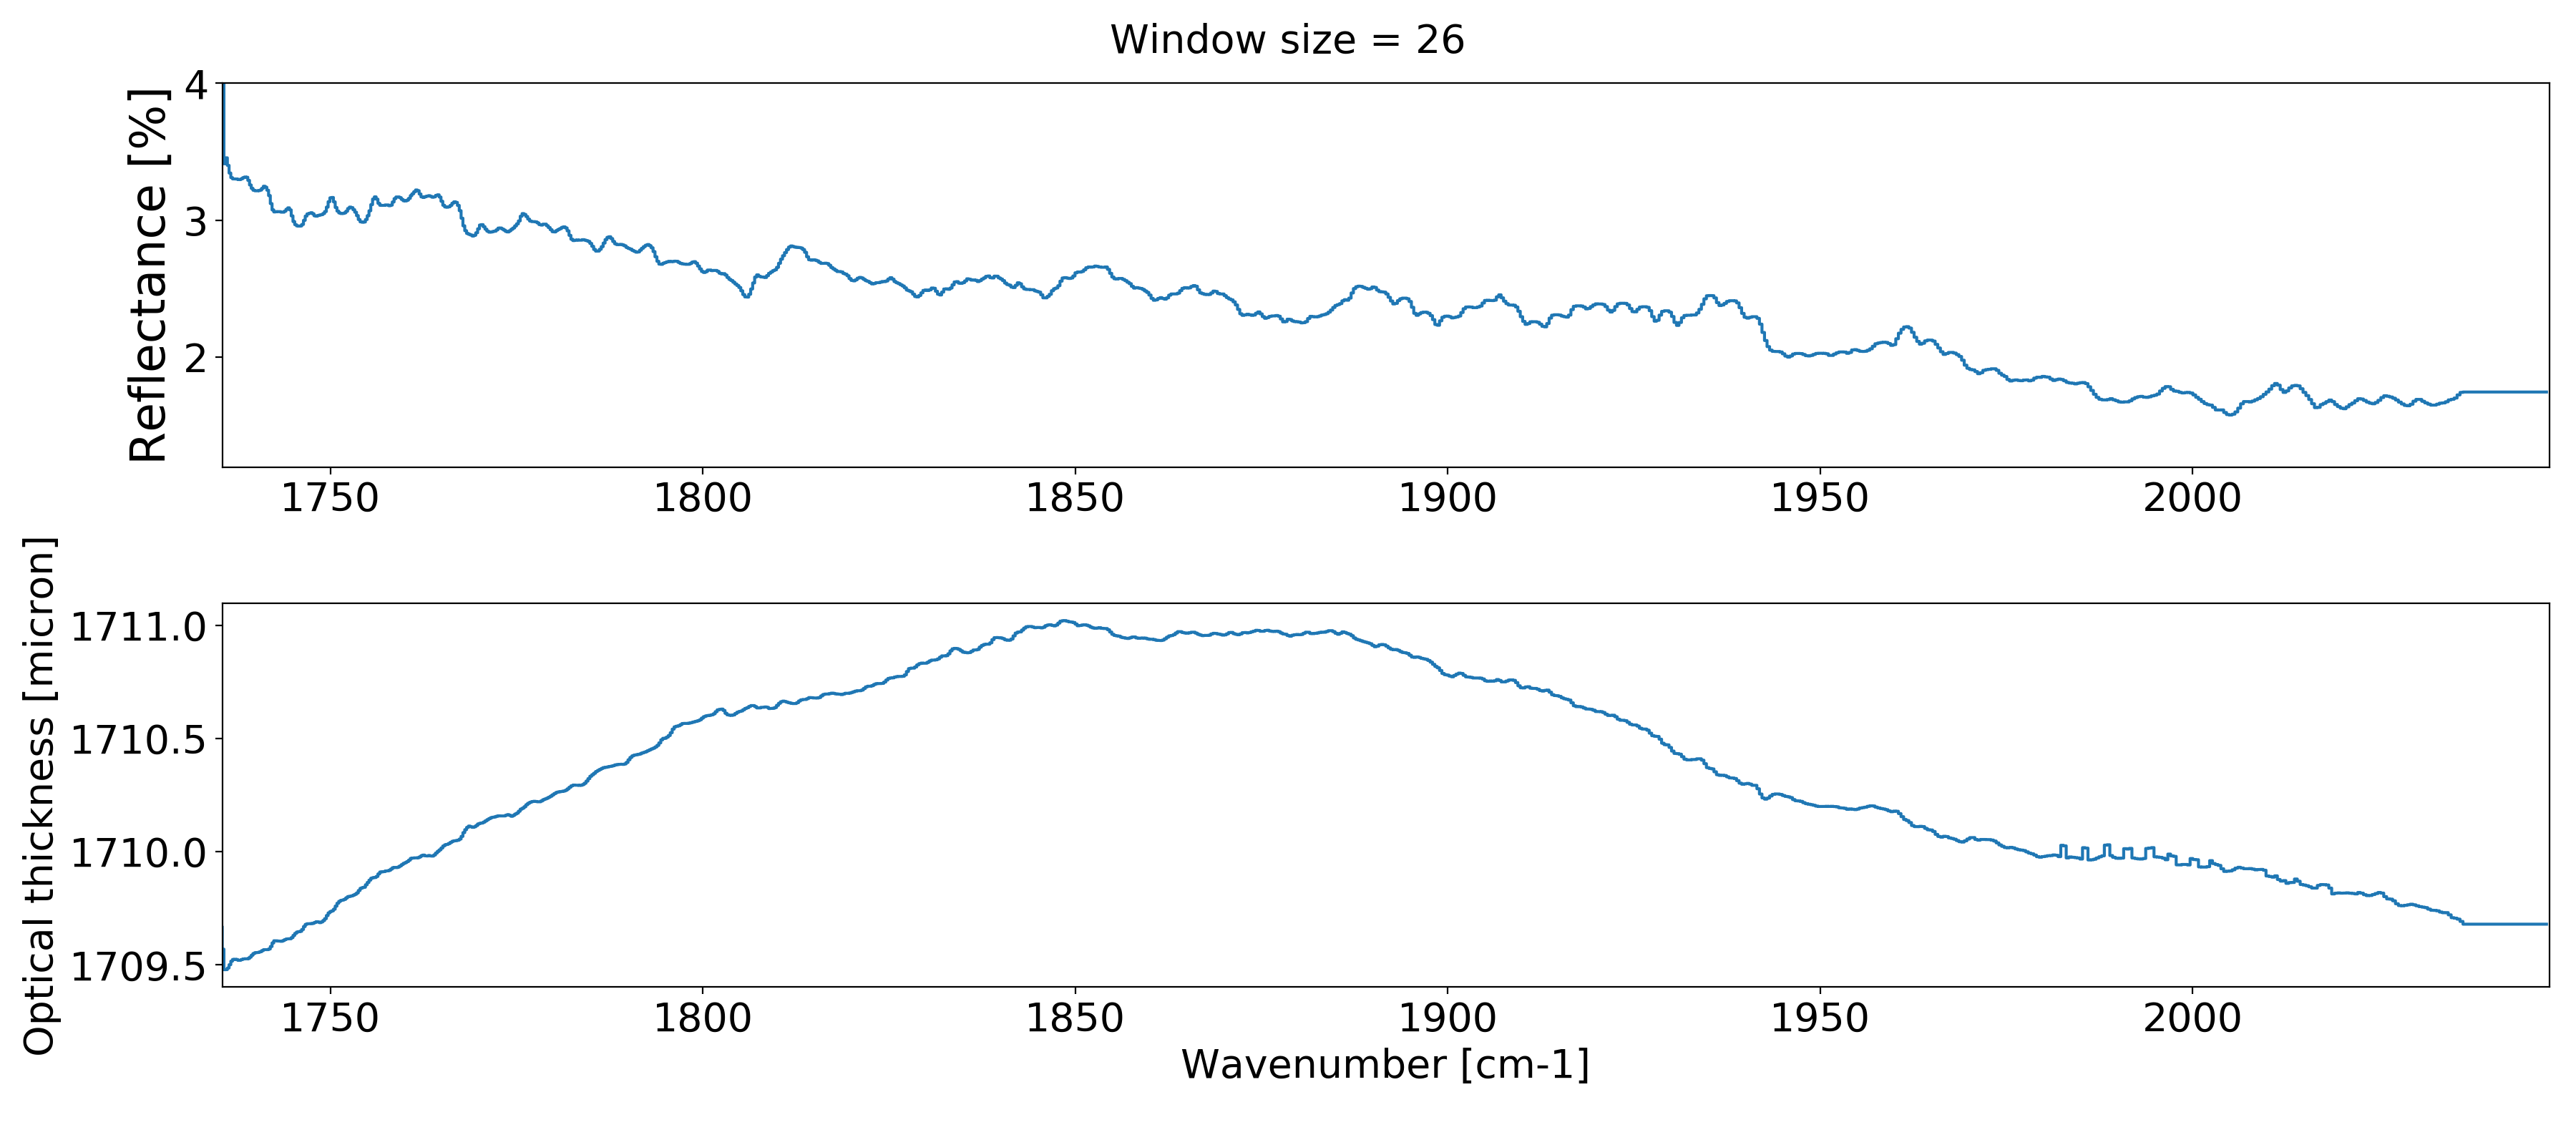

<IPython.core.display.Javascript object>


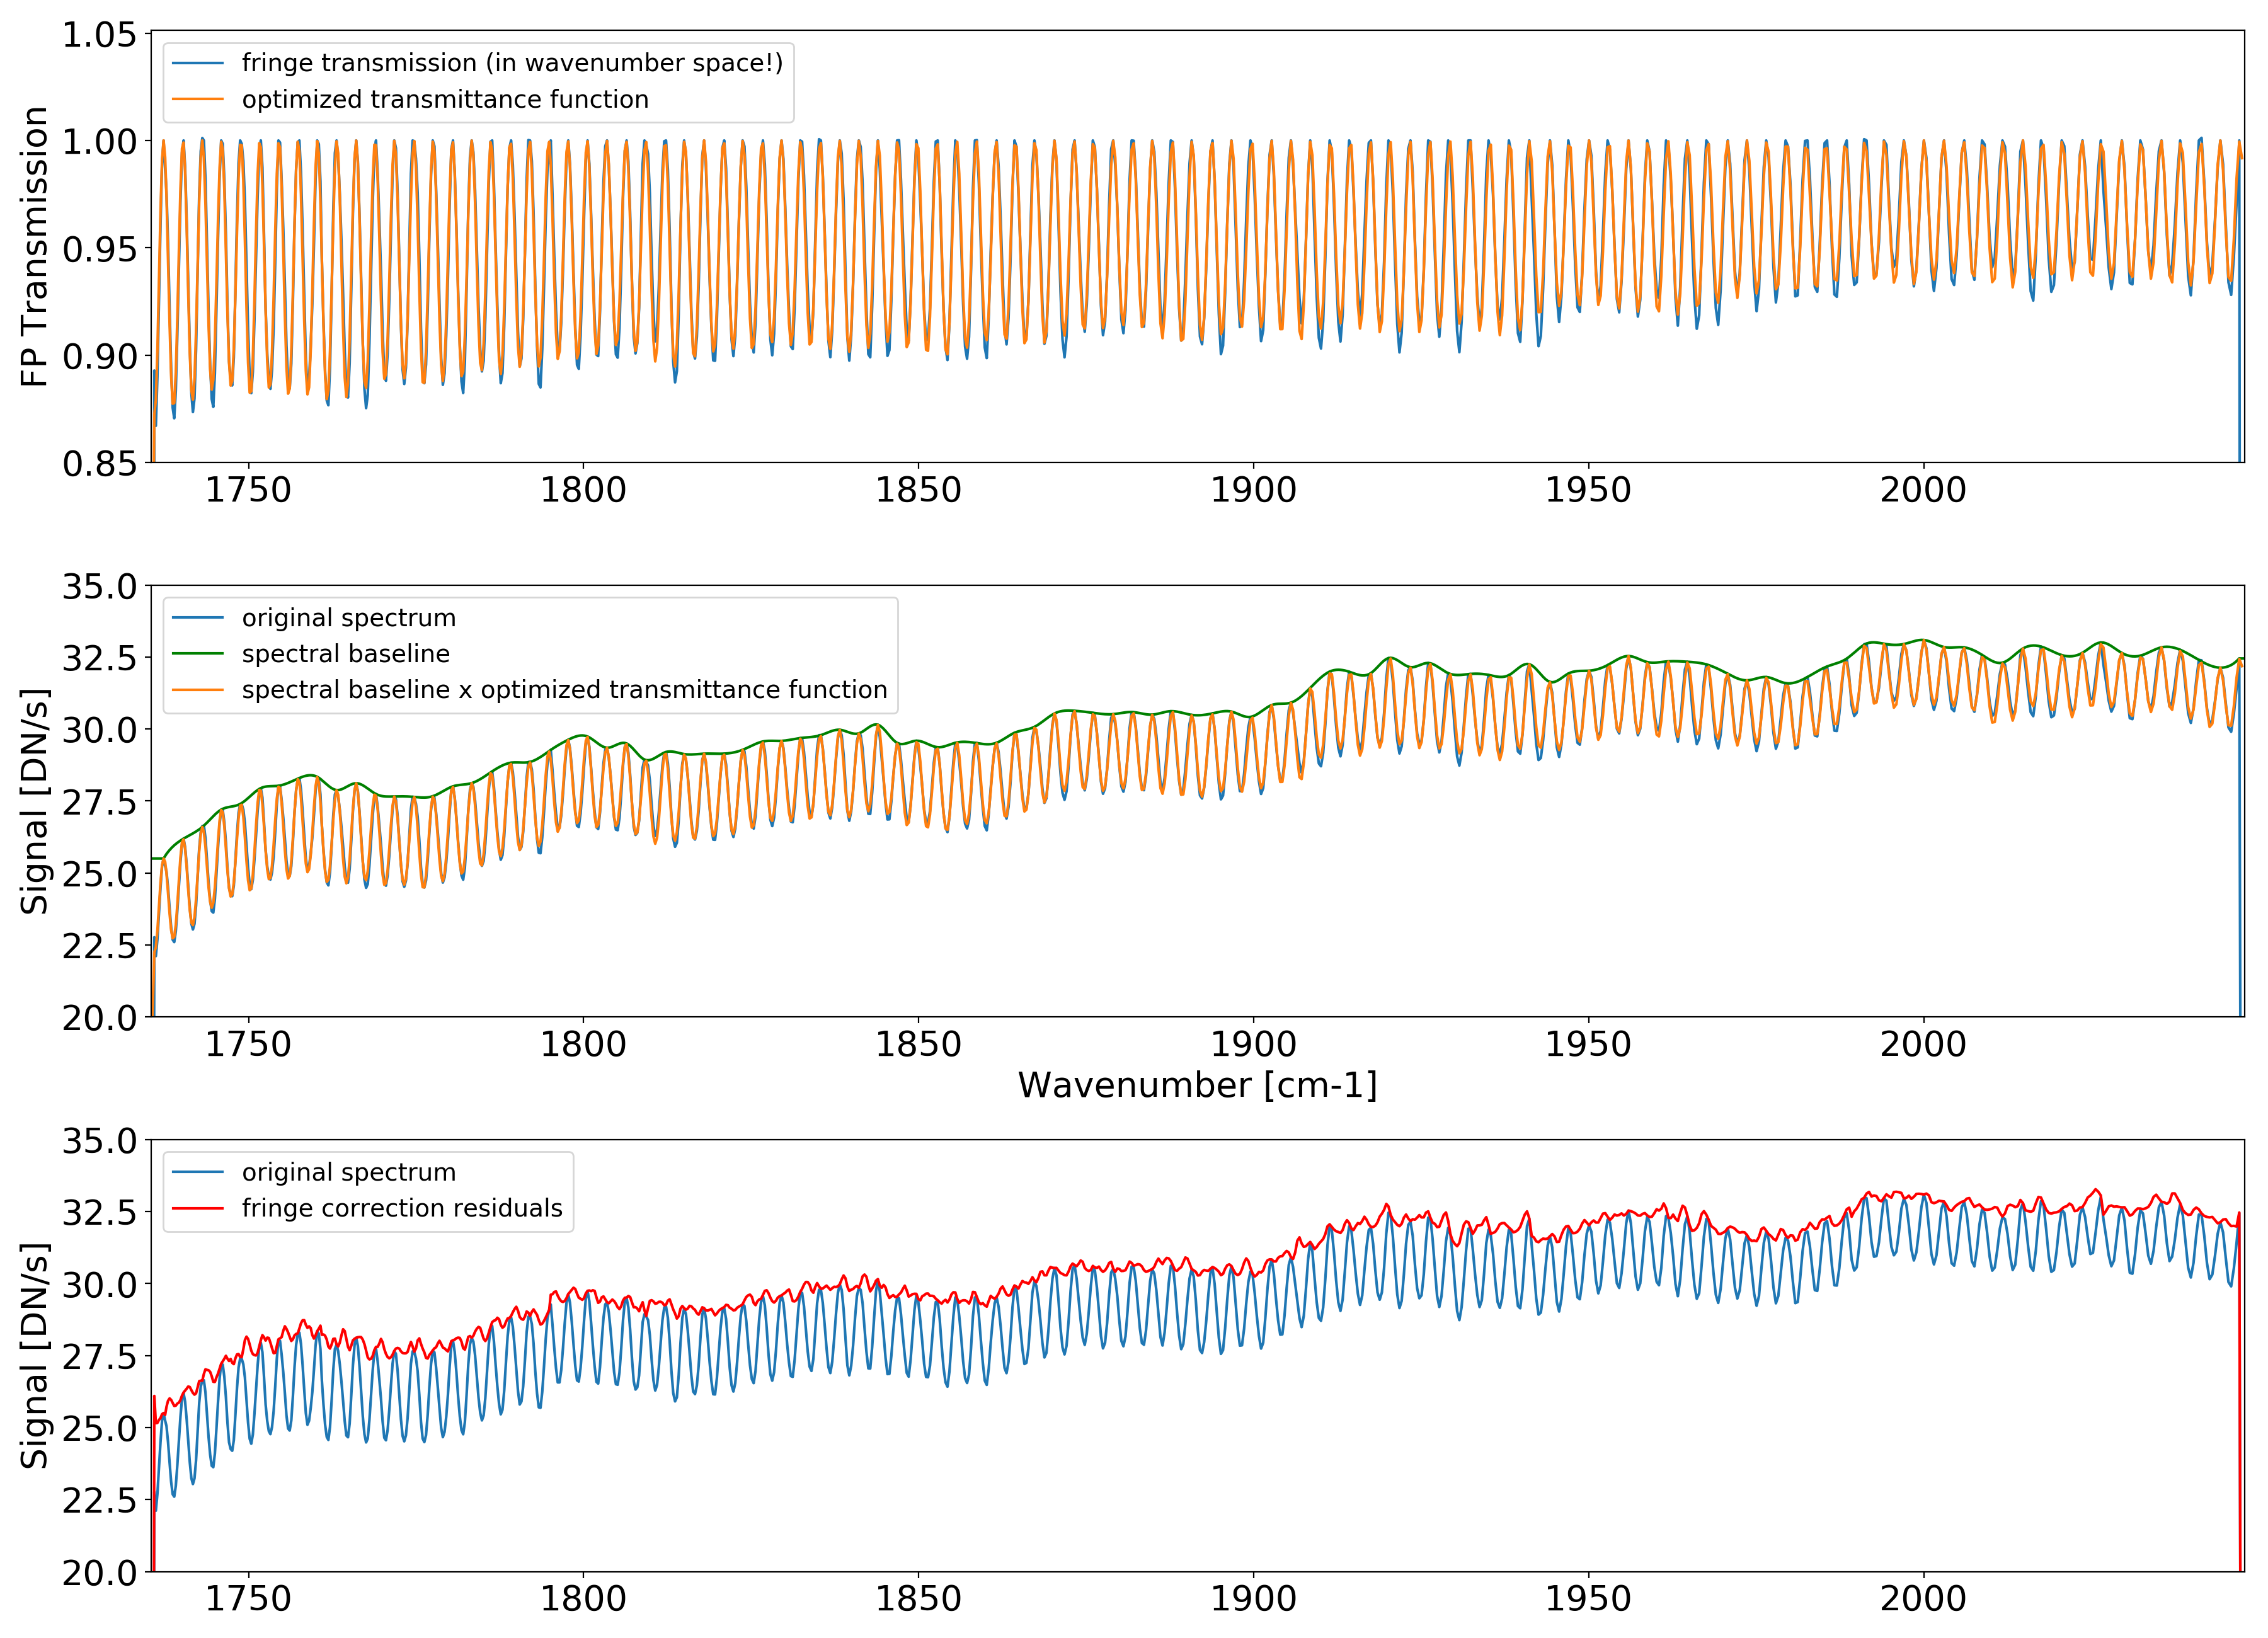

In [8]:
# let's look at the results
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].step(wavenumbers,R*100)
axs[0].set_xlim(wavenumbers[0],wavenumbers[-1])
axs[0].set_ylim(1.2,4)
axs[0].set_ylabel('Reflectance [%]',fontsize=24)
axs[1].step(wavenumbers,D*10000)
axs[1].set_xlim(wavenumbers[0],wavenumbers[-1])
axs[1].set_ylabel('Optical thickness [micron]')
axs[1].set_xlabel('Wavenumber [cm-1]')
plt.suptitle('Window size = {}'.format(N),fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# let's apply the optimized transmittance function
fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].plot(wavenumbers,norm_signal,label='fringe transmission (in wavenumber space!)')
axs[0].plot(wavenumbers,TR,label='optimized transmittance function')
axs[0].set_xlim(wavenumbers[0],wavenumbers[-1])
axs[0].set_ylim(0.85)
axs[0].set_ylabel('FP Transmission')
axs[1].plot(wavenumbers,np.flipud(ext_source_norm[0]),label='original spectrum')
axs[1].plot(wavenumbers,np.flipud(ext_source_norm[2]),'g',label='spectral baseline')
axs[1].plot(wavenumbers,np.flipud(ext_source_norm[2])*TR,label='spectral baseline x optimized transmittance function')
axs[1].set_ylim(20,35)
axs[1].set_xlim(wavenumbers[0],wavenumbers[-1])
axs[1].set_xlabel('Wavenumber [cm-1]')
axs[1].set_ylabel('Signal [DN/s]')
axs[2].plot(wavenumbers,np.flipud(ext_source_norm[0]),label='original spectrum')
axs[2].plot(wavenumbers,np.flipud(ext_source_norm[0])/TR,'r',label='fringe correction residuals')
axs[2].set_xlim(wavenumbers[0],wavenumbers[-1])
axs[2].set_ylim(20,35)
axs[2].set_ylabel('Signal [DN/s]')
for plot in range(3): axs[plot].legend(loc='upper left')
plt.tight_layout()

### Remarks:
* By "scanning" the fringe transmission and fitting a Fabry-Pérot transmittance function in each scan window, it is possible to probe the local optical properties of the MIRI SW detector.
* Much like in Notebook 7 - Test 1, we find an intensity reflectivity R of the order of two to three percent. Note that here we speak of an **effective** reflectivity. Namely an averaged quantity born from the reflectivity of the different detector layers, that yield the fringe amplitudes we see.
* For the optical thickness determination, we see a smooth curve over the wavenumber range. The "wavenumber range" in fact corresponds to a physical location on the detector (where light of a given wavelength is incident onto a given pixel). The variation of the optical thickness over the detector is of the order of 1.5um. Such a variation is very small indeed. Interestingly enough a private communication with Dr. Mike Ressler sheds light for a possible cause for the kind of variation seen:  
  
    From Dr. Mike Ressler: "*The biggest "non-flatness" term will be the warping of the chip due to how the detector is attached to the motherboard. This will be far larger than any other term from the actual wafer manufacturing process or the detector growth process. The detector surface typically looks like a potato chip (crisp, if you are in Britain), so you can expect 10-15 microns peak-to-peak variation of the surface (typically center is high, two opposing corners are low, the other two corners are in the middle).*"
  
    Given the above excerpt, it could be that the optical thickness variation measured probes the "warping of the chip" (center is high, sides are low). We show the value of the optical thickness as a function of detector pixel position below.

<IPython.core.display.Javascript object>


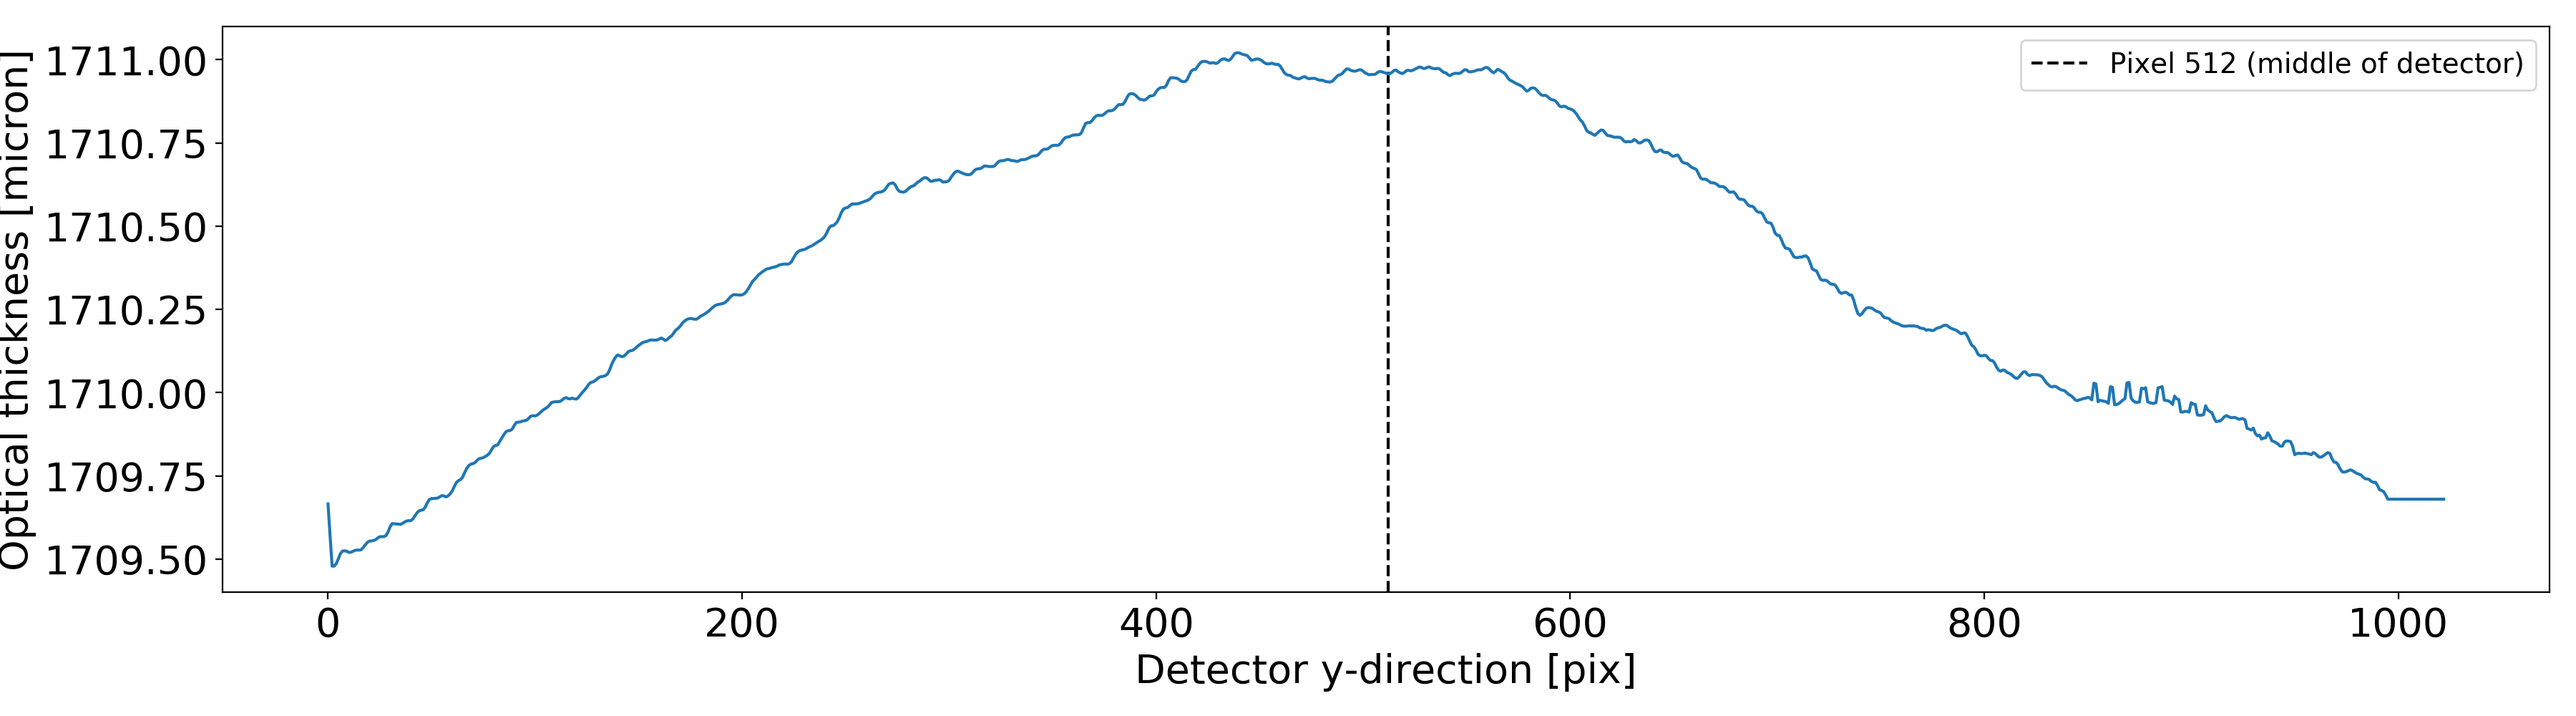

In [9]:
plt.figure(figsize=(18,5))
plt.plot(np.arange(1024),D*10000)
plt.vlines(512,1709.4,1711.1,linestyle='dashed',label='Pixel 512 (middle of detector)')
plt.ylim(1709.4,1711.1)
plt.ylabel('Optical thickness [micron]')
plt.xlabel('Detector y-direction [pix]')
plt.legend()
plt.tight_layout()

# [UNDER CONSTRUCTION]

## Conclusions:  

## Follow-up question:  
